# **Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"**

## **ID Group**: 07MIAR06 
## **Dataset**: Plant Seedlings Classification

### **Integrantes**: 
### Álvaro Sánchez Rocamora
### Daniel Abellán Sánchez
### Carlos Melgosa Durá


#### El código de la práctica se encuentra en el siguiente repositorio de GitHub: https://github.com/daniabellan/Plant-Seedlings-Classification

## Imports Librerías

In [1]:
import tensorflow as tf
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import numpy as np
import math

from sklearn.utils.class_weight import compute_class_weight

## Descarga de datos desde la plataforma Kaggle

### Para este proyecto se va a hacer uso del dataset de kaggle https://www.kaggle.com/c/plant-seedlings-classification/data

##### En esta ocasión, por dificultades en la descarga directa del dataset desde kaggle, hemos obtado por descargarlo y hacer uso de éste en local.

##### Dentro del repositorio de Github con el código, en la carpeta de *dataset/* disponemo de dos subcarpetas llamadas *test/* y *train/* con las muestras pertinentes a cada partición. Todo esto es respetando la jerarquía original del dataset.

# **1. Carga del conjunto de datos**

### Definimos las funciones necesarias para la carga de los datasets 

In [2]:
# Definimos un diccionario para mapear los nombres de las clases con sus índices
dict_map_class = {
    'Loose Silky-bent': 0,
    'Common Chickweed': 1,
    'Scentless Mayweed': 2,
    'Small-flowered Cranesbill': 3,
    'Fat Hen': 4,
    'Charlock': 5,
    'Sugar beet': 6,
    'Cleavers': 7,
    'Black-grass': 8,
    'Shepherds Purse': 9,
    'Common wheat': 10,
    'Maize': 11,   
}

# Invertimos el diccioanrio del mapeo de clases
dict_map_class_inverted = {v: k for k, v in dict_map_class.items()}


def get_dict_dataset(
    dataset_path: str = 'dataset'
):
    """
    Crea un diccionario que asigna las rutas de las imágenes a tuplas que contienen la clase y la partición.

    Args:
        dataset_path (str): Ruta al directorio del conjunto de datos. Por defecto, es 'dataset'.

    Returns:
        dict: Un diccionario donde las claves son las rutas de las imágenes y los valores son tuplas (clase, partición).
    """

    dict_dataset = {}

    train_classes = os.listdir(os.path.join(dataset_path, 'train'))

    for train_class in train_classes:
        class_path = os.path.join(dataset_path, 'train', train_class)
        train_imgs = os.listdir(class_path)
        
        # Split Train images to a 80% for a Train Split for each class
        for train_img in train_imgs[:int(len(train_imgs)*0.8)]:
            train_img_path = os.path.join(class_path, train_img)
            dict_dataset[train_img_path] = (dict_map_class[train_class], 'Train')

        # Assign the rest 20% to Valid Split for each class
        for valid_img in train_imgs[int(len(train_imgs)*0.8):]:
            valid_img_path = os.path.join(class_path, valid_img)
            dict_dataset[valid_img_path] = (dict_map_class[train_class], 'Valid')

    # Geting Test Images
    test_path = os.path.join(dataset_path, 'test')
    test_imgs = os.listdir(test_path)

    for test_img in test_imgs:
        test_img_path = os.path.join(test_path, test_img)
        dict_dataset[test_img_path] = ("Unkown", 'Test')

    return dict_dataset


def dict2dataframe(
    input_dict: Dict[str, Tuple]
):
    """
    Convierte un diccionario a un DataFrame de pandas con columnas para 'path', 'label', y 'split'.

    Args:
        input_dict (dict): Un diccionario donde las claves son las rutas de las imágenes y los valores son tuplas (etiqueta, división).

    Returns:
        pd.DataFrame: Un DataFrame con columnas 'path', 'label' y 'split'.
    """
    df = pd.DataFrame([(key, values[0], values[1]) for key, values in input_dict.items()], columns=['path', 'label', 'split'])

    # Returns shuffled datasets
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

### Definimos las funciones para la creación del Datset de TensorFlow

In [5]:
def tf_augmenter():
    """
    Devuelve una función de TensorFlow para la aumentación de datos.

    La función devuelta aplica transformaciones aleatorias a las imágenes de entrada,
    incluyendo volteos aleatorios (arriba-abajo y izquierda-derecha), ajustes de brillo aleatorios,
    y ajustes de contraste aleatorios.

    Returns:
        callable: Una función de TensorFlow que toma un número variable de argumentos (tensores)
                  representando el conjunto de datos y aplica aumentación de datos a las imágenes.
    """
    @tf.function
    def f(*dataset):
        output= list(dataset)
        image = output[0]
        
        # De manera probabilística, con 50% de que ocurra, se aplicará
        # una de estas transformaciones
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_flip_up_down(image)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_flip_left_right(image)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_brightness(image, 0.15)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.7:
            image = tf.image.random_contrast(image, 0.6, 1.4)

        output[0] = image
        return output
    return f


@tf.function
def load_image(*inputs):
    """
    Función de TensorFlow para cargar una imagen utilizando una función de NumPy.

    Args:
        *inputs: Número variable de tensores de entrada.

    Returns:
        list: Una lista de tensores de salida con la imagen cargada como primer elemento.
    """
    outputs = list(inputs)
    image = tf.numpy_function(load_image_np, [inputs[0]], tf.float32)
    image.set_shape([None, None, 3])
    outputs[0] = image
    
    return outputs


def load_image_np(path):
    """
    Carga una imagen con PIL desde la ruta especificada y la convierte en un array de NumPy.

    Args:
        path (str): La ruta al archivo de la imagen.

    Returns:
        np.ndarray: Un array de NumPy que representa la imagen cargada en formato RGB.
    """
    return np.array(Image.open(path).convert('RGB')).astype(np.float32)


def resize(index=0, resize_to=None):
    """
    Devuelve una función de TensorFlow para cambiar el tamaño de una imagen en un conjunto de datos.

    Args:
        index (int): Índice del tensor de la imagen en el conjunto de datos. Por defecto, es 0.
        resize_to (tuple, list o None): Tamaño objetivo para cambiar el tamaño. Si es None, no se realiza ningún cambio de tamaño. Por defecto, es None.

    Returns:
        callable: Una función de TensorFlow que cambia el tamaño de la imagen en el conjunto de datos.
    """
    def f(*dataset):
        output = list(dataset)
        # Hacemos resize al input size deseado
        resized_image = tf.image.resize(dataset[index], resize_to)
        # Casteamos de nuevo a uint8 para dejar la imagen entre 0 y 255
        resized_image = tf.cast(resized_image, tf.uint8)
        output[index] = resized_image
        
        return output
    return f


def preprocess_input(index):
    """
    Devuelve una función de TensorFlow para preprocesar una imagen en un conjunto de datos.

    Args:
        index (int): Índice del tensor de la imagen en el conjunto de datos.

    Returns:
        callable: Una función de TensorFlow que preprocesa la imagen en el conjunto de datos.
    """
    @tf.function
    def f(*dataset):
        output = list(dataset)
        image = dataset[index]
        # Convertimos a tf.float32 la imagen
        image = tf.cast(image, tf.float32)
        # Normalizamos la imagen entre 0 y 1
        image = image / 255.
        output[index] = image
        
        return output
    return f


def get_dataset(
    df: pd.DataFrame,
    input_size: Tuple[int, int],
    shuffle: bool = False,
    batch_size: int = None,
    gray_scale: bool = False,
    augmenter: bool = False,
    num_aug: int = None,
    test_set: bool = False
)->tf.data.Dataset:
    """
    Crea un dataset de TensorFlow a partir de un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame que contiene información sobre el conjunto de datos.
        input_size (Tuple[int, int]): Tupla que representa el tamaño objetivo para cambiar el tamaño de las imágenes.
        shuffle (bool): Si se debe barajar el conjunto de datos. Por defecto, es False.
        batch_size (int): Tamaño del lote para el conjunto de datos. Si es None, no se realiza agrupamiento. Por defecto, es None.
        gray_scale (bool): Si se deben convertir las imágenes a escala de grises. Por defecto, es False.
        augmenter (bool): Si se debe aplicar aumentación de datos. Por defecto, es False.
        num_aug (int): Número de aumentaciones a aplicar si augmenter es True. Por defecto, es None.
        test_set (bool): Si el conjunto de datos es un conjunto de prueba. Por defecto, es False.

    Returns:
        tf.data.Dataset: Un conjunto de datos de TensorFlow preparado según las opciones proporcionadas.
    """
    # Imprimir información sobre la distribución de las etiquetas
    print('Number of instances per label: ',
          pd.Series(df['label']).value_counts(), sep='\n')
    print('\nPercentaje of instances per label: ',
          pd.Series(df['label']).value_counts().div(pd.Series(df['label']).shape[0]),
          sep='\n')

    names = np.array(df['path'], dtype=str)

    if not test_set:
        labels = np.array(tf.keras.utils.to_categorical(df['label'], num_classes=12))
    else:
        labels = np.ones(len(names))

    data = names, labels

    # Creamos un dataet de TensorFlow a partir de las rutas y etiquetas
    dataset = tf.data.Dataset.from_tensor_slices(data)

    # Barajamos el dataset
    if shuffle:
        print(' > Shuffle')
        dataset = dataset.shuffle(len(names))

    # Cargamos las imagenes
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Aplicamos el resize
    dataset = dataset.map(resize(resize_to=input_size), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Aumentamos los datos
    if augmenter:
        print(f' > Augmentamos datos numero {num_aug}')
        if num_aug == 1:
            dataset = dataset.map(tf_augmenter(), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Preprocesamos las entradas
    dataset = dataset.map(preprocess_input(0), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Convertimos a escala de grises
    if gray_scale:
        print(' > Escala de grises')
        dataset = dataset.map(lambda *args: (tf.image.rgb_to_grayscale(args[0]), *args[1:]))

    # Definimos el batch size
    if batch_size is not None:
        print(' > Establecemos el batchsize')
        dataset = dataset.batch(batch_size)
    
    # Prefetch para paralelizar los siguientes batches mientras se evalua un batch
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

### Cargamos el dataset en un pd.DataFrame y visualizamos los datos

In [7]:
dict_dataset = get_dict_dataset(dataset_path="dataset/")

# Creamos el DataFrame 
df_dataset = dict2dataframe(dict_dataset)
df_dataset

path   label  split
0     dataset/train\Scentless Mayweed\8c496e84a.png       2  Train
1          dataset/train\Common wheat\4a56f32c6.png      10  Train
2                        dataset/test\99569b224.png  Unkown   Test
3           dataset/train\Black-grass\e0380dff9.png       8  Valid
4               dataset/train\Fat Hen\9708f9c0e.png       4  Train
...                                             ...     ...    ...
5539    dataset/train\Shepherds Purse\953ced7c6.png       9  Train
5540                     dataset/test\8cf909eb3.png  Unkown   Test
5541                     dataset/test\98062cd87.png  Unkown   Test
5542                     dataset/test\cc3d2a59a.png  Unkown   Test
5543           dataset/train\Cleavers\b6220c08e.png       7  Train

[5544 rows x 3 columns]

#### En el DataFrame anterior podemos visualizar por cada índice, el path de la imagen junto a su etiqueta asociada y al split que perteneces (Train, Valid o Test).

#### Aquellas imagenes pertenecientes a Test presentan la etiqueta de Unkown. Esto se debe a que el dataset de kaggle no tiene el dataset de test etiquetado, por ello para diferenciarlo aún más le ponemos esta etiqueta.

# **2. Inspección del conjunto de datos**

#### Dado que ya disponemos del DataFrame con todas las muestras, vamos a crear cada partición y a su vez, visualizar las distribuciones de las etiquetas por cada uno de los splits.

In [8]:
# Creamos dataset de Train
df_dataset_train = df_dataset[df_dataset['split'] == 'Train'].drop(columns=['split'])
df_dataset_train

path label
0         dataset/train\Scentless Mayweed\8c496e84a.png     2
1              dataset/train\Common wheat\4a56f32c6.png    10
4                   dataset/train\Fat Hen\9708f9c0e.png     4
5                dataset/train\Sugar beet\6d623072a.png     6
8     dataset/train\Small-flowered Cranesbill\869252...     3
...                                                 ...   ...
5534      dataset/train\Scentless Mayweed\948251df3.png     2
5535             dataset/train\Sugar beet\29a0e6bf9.png     6
5537               dataset/train\Charlock\8b35222d0.png     5
5539        dataset/train\Shepherds Purse\953ced7c6.png     9
5543               dataset/train\Cleavers\b6220c08e.png     7

[3794 rows x 2 columns]

In [9]:
# Visualizamos distribuciones por clase
df_dataset_train['label'].value_counts()

0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: label, dtype: int64

##### Si nos fijamos en la distribución de muestras por clases del splir de train podemos ver como se presenta un desbalanceo de clases notable. Podemos ver como de la clase 0 disponemos de 523 muestras, mientras que de la clase 11 disponemos nomás de 176 muestras.

##### Dado este desbalanceo, se va a obtar por entrenar los modelos pasándoles los pesos de cada una de las clases mediante el netodo *compute_class_weight()* de la librería de *sklearn*.

##### Otra opción era duplicar las muestras de las clases minoritarias e igualar las muestras de la mayoritaria, pero esto supondría la repetición de muchas imágenes iguales y se ha descartado

In [27]:
# Calculamos los pesos de cada clase debido al desbalanceo de las clases
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(df_dataset_train['label'].values),
                                     y=df_dataset_train['label'].values
)

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 0.6045251752708731,
 1: 0.6478825136612022,
 2: 0.7673948220064725,
 3: 0.7984006734006734,
 4: 0.8320175438596491,
 5: 1.0133547008547008,
 6: 1.0265151515151516,
 7: 1.3806404657933042,
 8: 1.5055555555555555,
 9: 1.7182971014492754,
 10: 1.7964015151515151,
 11: 1.7964015151515151}

##### Por lo que para calcular los pesos de las clases, que posteriormente se les pasarán en el fit del modelo, se hace uso del siguiente código. 

##### Del resultado podemos ver como las clases minoritarias presentan mayor peso que las que tienen mas presencia en nuestro dataset. Por ello, de las clases con mayor peso, la red ponderará más.

##### Este cálculo de los pesos sólo lo haremos para el set de Train, para los otros no es necesario

In [10]:
# Creamos dataset de Validación
df_dataset_valid = df_dataset[df_dataset['split'] == 'Valid'].drop(columns=['split'])
df_dataset_valid

path label
3               dataset/train\Black-grass\e0380dff9.png     8
10        dataset/train\Scentless Mayweed\d748c7307.png     2
15                  dataset/train\Fat Hen\e6b756e98.png     4
22    dataset/train\Small-flowered Cranesbill\ecf58a...     3
24                 dataset/train\Charlock\d1b362c43.png     5
...                                                 ...   ...
5500       dataset/train\Loose Silky-bent\fc2b27fff.png     0
5501               dataset/train\Charlock\fc3e15a2e.png     5
5503      dataset/train\Scentless Mayweed\d1e775b97.png     2
5505       dataset/train\Common Chickweed\f50c8181a.png     1
5538                  dataset/train\Maize\e30accd2f.png    11

[956 rows x 2 columns]

In [11]:
# Visualizamos distribuciones por clase
df_dataset_valid['label'].value_counts()

0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: label, dtype: int64

In [12]:
# Creamos dataset de Test
df_dataset_test = df_dataset[df_dataset['split'] == 'Test'].drop(columns=['split'])
df_dataset_test

path   label
2     dataset/test\99569b224.png  Unkown
6     dataset/test\d14aa43f3.png  Unkown
7     dataset/test\b47691c08.png  Unkown
12    dataset/test\19fdf19fb.png  Unkown
14    dataset/test\7d4cd07ad.png  Unkown
...                          ...     ...
5526  dataset/test\b30ab4659.png  Unkown
5536  dataset/test\bb1c84bbc.png  Unkown
5540  dataset/test\8cf909eb3.png  Unkown
5541  dataset/test\98062cd87.png  Unkown
5542  dataset/test\cc3d2a59a.png  Unkown

[794 rows x 2 columns]

In [13]:
# Visualizamos distribuciones por clase
df_dataset_test['label'].value_counts()

Unkown    794
Name: label, dtype: int64

#### Vistas las distribuciones de muestras por Split, vamos a visualizar unas muestras del Entrenamiento.

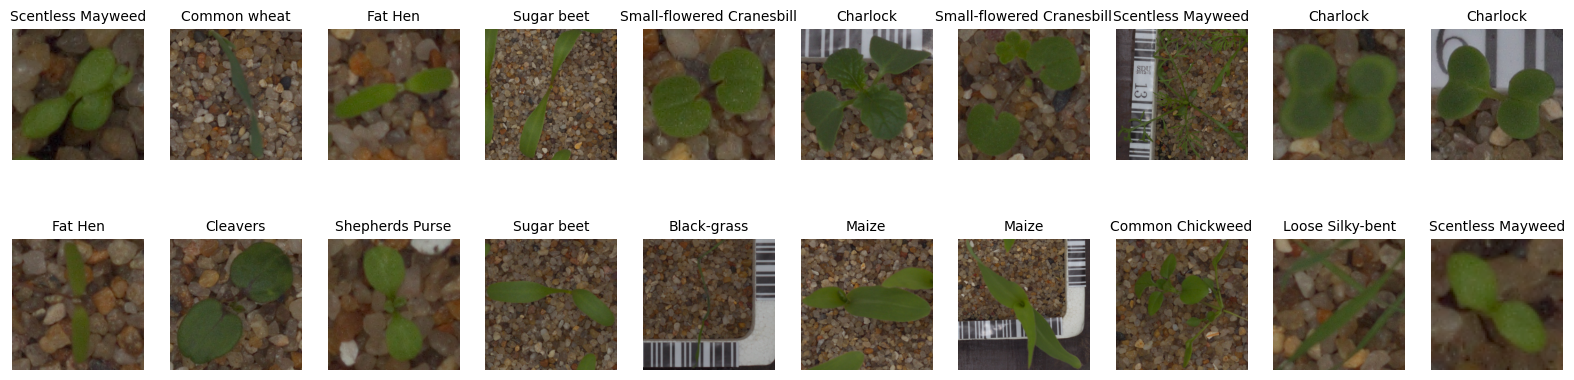

In [28]:
fig = plt.figure(figsize = (20, 5))

for i in range(20):
    img = Image.open(df_dataset_train.iloc[i]['path'])
    ax = fig.add_subplot(2, 10, i + 1)
    ax.imshow(img.convert('RGB'))
    title = dict_map_class_inverted[df_dataset_train.iloc[i]['label']]
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# **3. Acondicionamiento del conjunto de datos**

#### Creados los Splits para el Dataset original, podemos pasar a preparar un ejemplo de los TensorFlow Datasets pertinentes para cada uno de los Splits (Train, Val y Test) que se van a usar para las siguientes pruebas. A su vez, también los visualizaremos para ver qué imagenes entrarían a la red

In [30]:
# Creamos un ejemplo de datastet de train
train_tfdataset = get_dataset(
    df=df_dataset_train,
    input_size=(224,224),
    batch_size=16,
    shuffle=True,
    gray_scale=False,
    augmenter=True,
    num_aug=1,
)

train_tfdataset

Number of instances per label: 
0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: label, dtype: int64

Percentaje of instances per label: 
0     0.137849
1     0.128624
2     0.108593
3     0.104375
4     0.100158
5     0.082235
6     0.081181
7     0.060358
8     0.055351
9     0.048498
10    0.046389
11    0.046389
Name: label, dtype: float64
 > Shuffle
 > Augmentamos datos numero 1
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

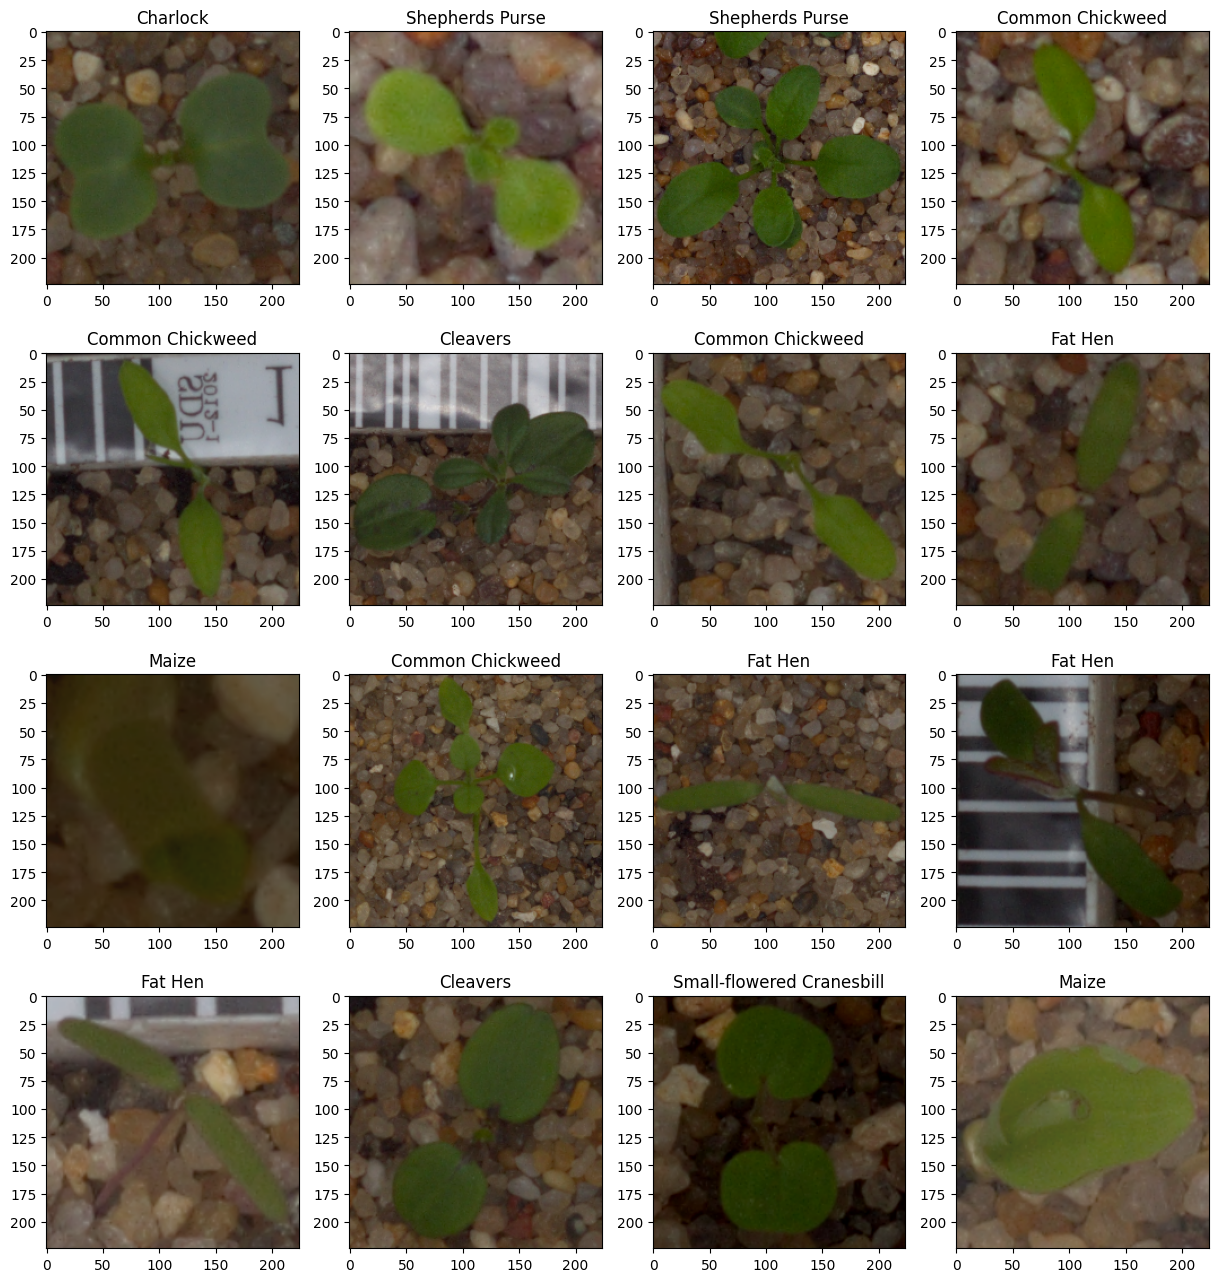

In [31]:
# Visualizamos dataset de Train
batch = next(iter(train_tfdataset))

batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)

In [32]:
# Creamos un ejemplo de datastet de Validacion
valid_tfdataset = get_dataset(
    df=df_dataset_valid,
    input_size=(224,224),
    batch_size=16,
    shuffle=True,
    gray_scale=False,
    augmenter=False,
)

valid_tfdataset

Number of instances per label: 
0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: label, dtype: int64

Percentaje of instances per label: 
0     0.137029
1     0.128661
2     0.108787
3     0.104603
4     0.099372
5     0.081590
6     0.080544
7     0.060669
8     0.055439
9     0.049163
11    0.047071
10    0.047071
Name: label, dtype: float64
 > Shuffle
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

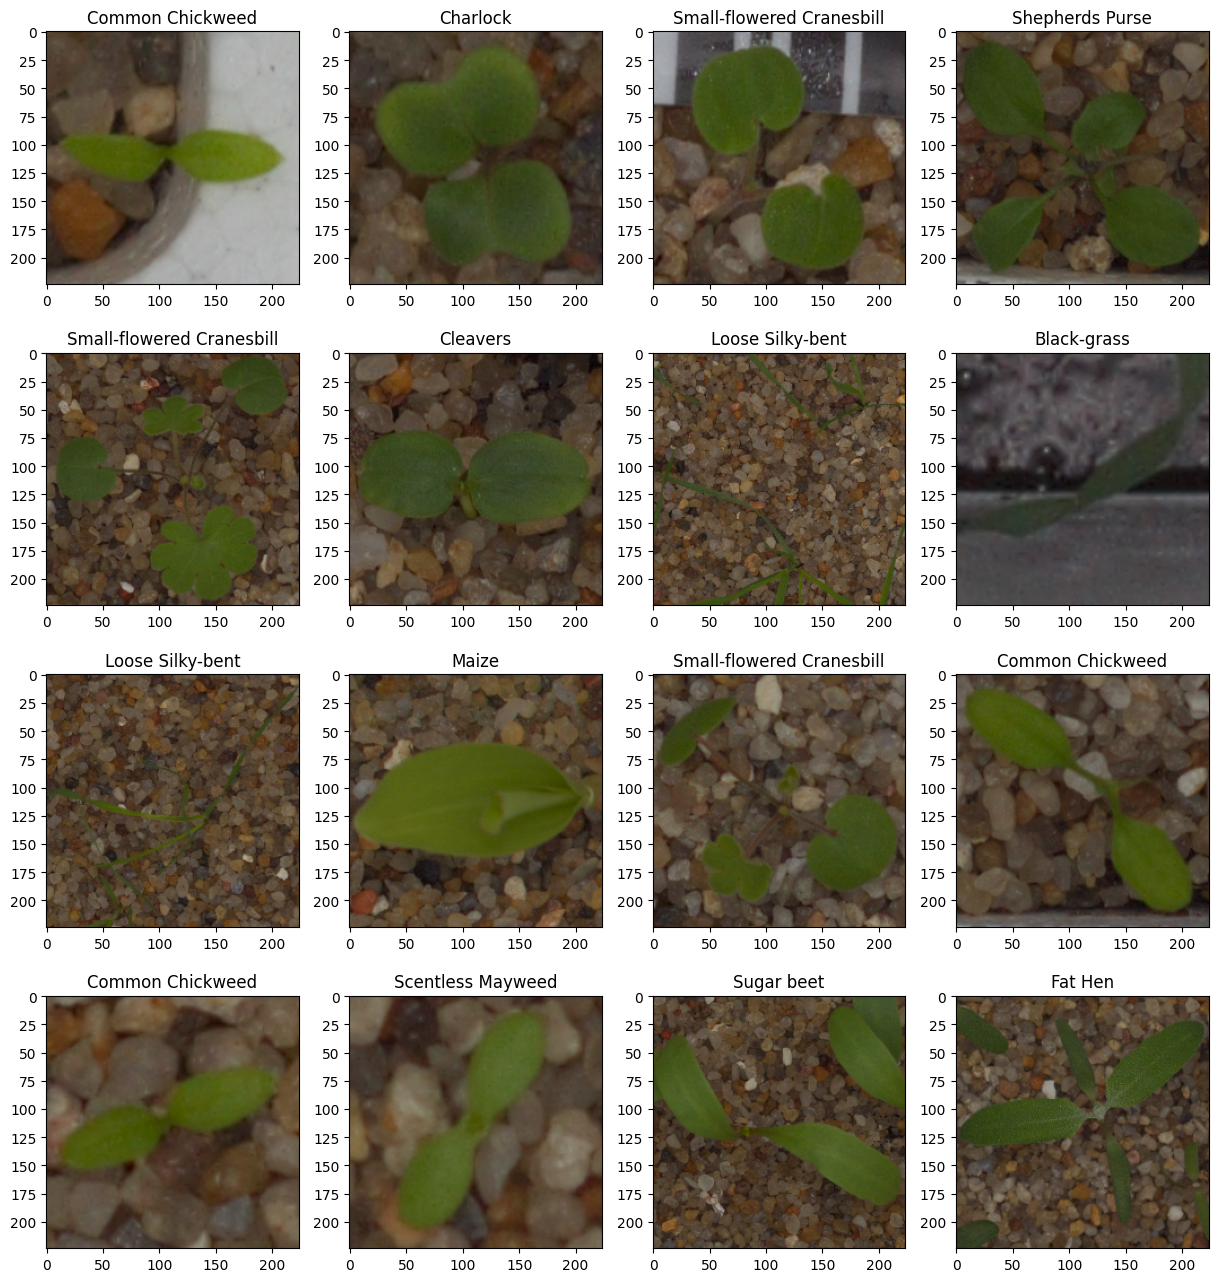

In [33]:
# Visualizamos dataset de Train
batch = next(iter(valid_tfdataset))

batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)

In [34]:
# Creamos un ejemplo de datastet de test
test_tfdataset = get_dataset(
    df=df_dataset_test,
    input_size=(224,224),
    batch_size=16,
    gray_scale=False,
    augmenter=False,
    test_set=True,
)

test_tfdataset

Number of instances per label: 
Unkown    794
Name: label, dtype: int64

Percentaje of instances per label: 
Unkown    1.0
Name: label, dtype: float64
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

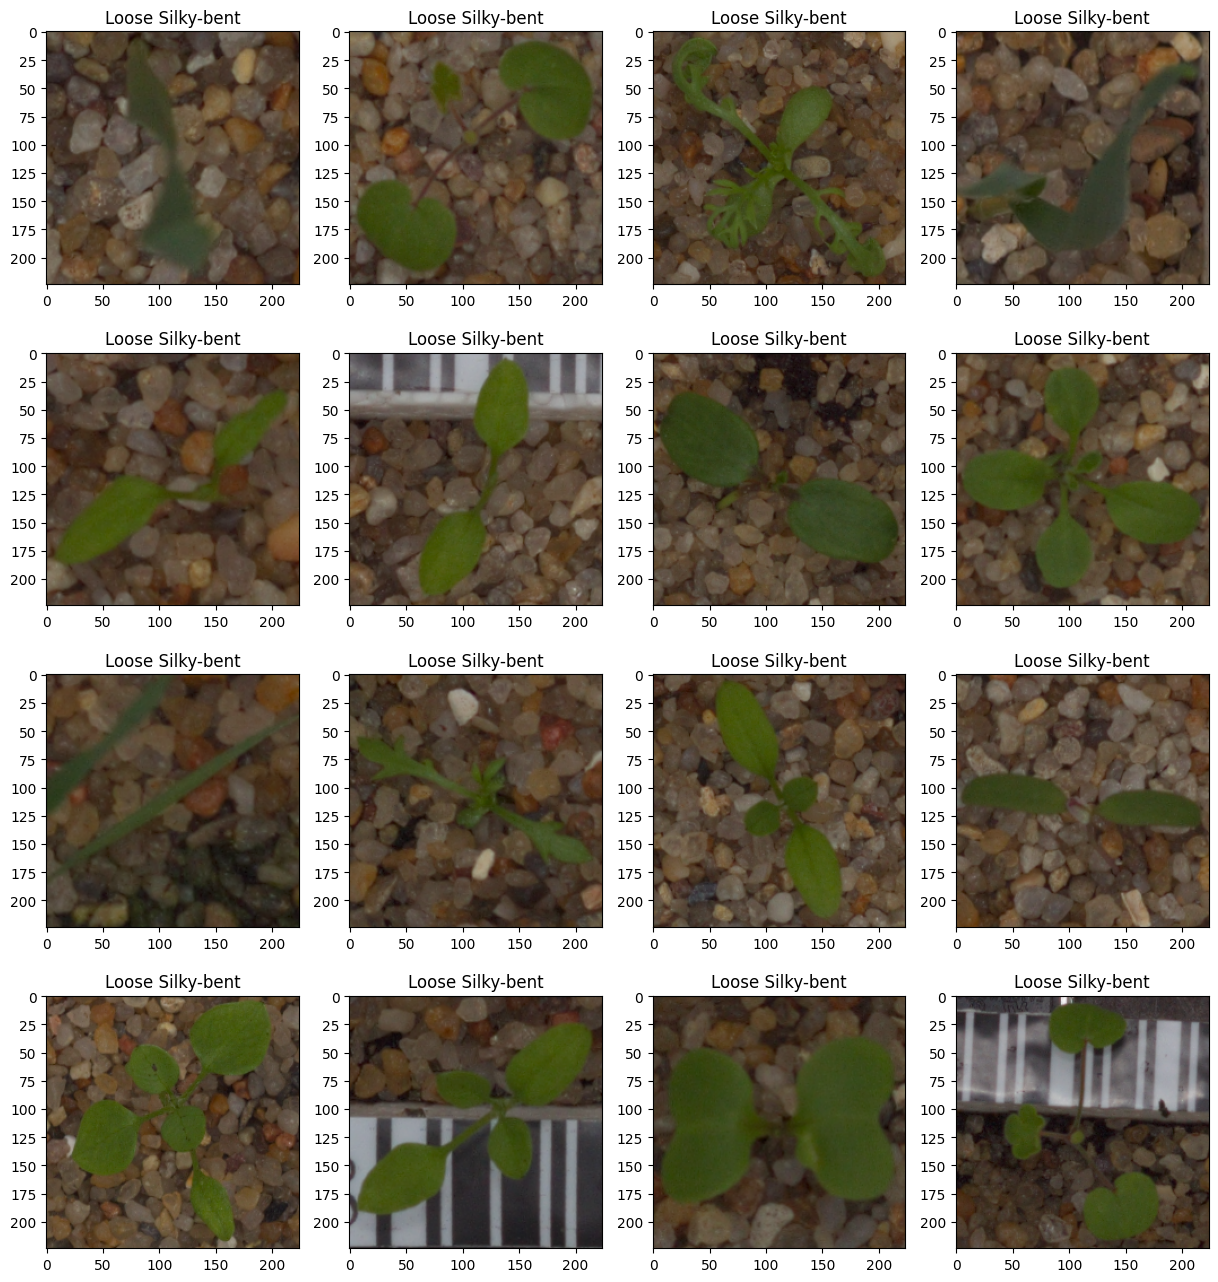

In [35]:
# Visualizamos dataset de Test
batch = next(iter(test_tfdataset))

batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)